SAT-6 Exploratory Data Analysis
===

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
np.random.seed(1)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Data Format
---

The data has been saved in two formats. The `sat-6-full.mat` contains all of the data in MATLAB format. It can be loaded in with `scipy` as a dictionary with each key holding a partition. The data is also divided into respective `.csv` files. While this format is more convenient, it is markedly slower to load than the MATLAB format. For the EDA, I will use the `.csv` format.

In [2]:
data_dir = '/Users/tyler/Datasets/deepsat-sat6/'

In [3]:
os.listdir(data_dir)

['y_test_sat6.csv',
 'sat-6-full.mat',
 'X_train_sat6.csv',
 'sat6annotations.csv',
 'y_train_sat6.csv',
 'X_test_sat6.csv']

In [4]:
# How to load MATLAB file:
# dataset = scipy.io.loadmat(data_dir+'sat-6-full.mat')

Dataset Size and Shape
---
In all there are **405,000 images** with **324,000 images in the training set** and **81,000 images in the test set**, which gives us a **train/test split of 80/20**.

There are six classes for classification: `building`, `barren_land`,`trees`, `grassland`, `road`, `water`.

Each image is 28x28 with 4 channels: R (red), G (green), B (blue), and IR (infrared). Together, these dimensions and channels require 3,126 columns to represent the image as a row vector.

Each label is a 1x6 row vector. Below is the table of values for the labels:

In [5]:
label_table = pd.read_csv(data_dir+'sat6annotations.csv', header=None)
label_table

,0,1,2,3,4,5,6
0,building,1,0,0,0,0,0
1,barren_land,0,1,0,0,0,0
2,trees,0,0,1,0,0,0
3,grassland,0,0,0,1,0,0
4,road,0,0,0,0,1,0
5,water,0,0,0,0,0,1


Distribution of Classes
---
An important question for any classification project is whether each class is well represented.

As we see in the charts below, the train and test set have a similar distribution of the six classes. `building` and `road` each have low representation in the datasets (less than 5%).

In [6]:
classes = ['building', 'barren_land','trees', 'grassland', 'road', 'water']
training_labels = pd.read_csv(data_dir+'y_train_sat6.csv', header=None)
training_labels.columns = classes
training_labels[:5]

,building,barren_land,trees,grassland,road,water
0,0,0,1,0,0,0
1,0,1,0,0,0,0
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,0,0,0,0,1


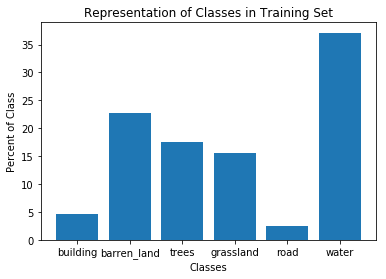

In [7]:
perc_of_class_train = {x: round(training_labels[x].sum()/324000, 3) * 100 for (i, x) in enumerate(classes)}
plt.bar(range(len(perc_of_class_train)), list(perc_of_class_train.values()), align='center')
plt.xticks(range(len(perc_of_class_train)), list(perc_of_class_train.keys()))
plt.ylabel('Percent of Class')
plt.xlabel('Classes')
plt.title('Representation of Classes in Training Set')
plt.show()

In [8]:
perc_of_class_train

{'building': 4.6,
 'barren_land': 22.7,
 'trees': 17.5,
 'grassland': 15.5,
 'road': 2.5,
 'water': 37.1}

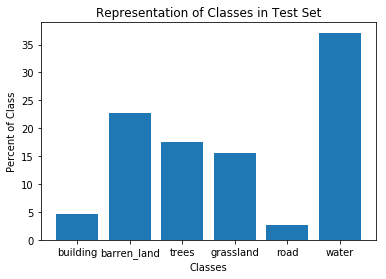

In [9]:
test_labels = pd.read_csv(data_dir+'y_test_sat6.csv', header=None)
test_labels.columns = classes
perc_of_class_test = {x: round(test_labels[x].sum()/81000, 3) * 100 for (i, x) in enumerate(classes)}
plt.bar(range(len(perc_of_class_test)), list(perc_of_class_test.values()), align='center')
plt.xticks(range(len(perc_of_class_test)), list(perc_of_class_test.keys()))
plt.ylabel('Percent of Class')
plt.xlabel('Classes')
plt.title('Representation of Classes in Test Set')
plt.show()

In [10]:
perc_of_class_test

{'building': 4.6,
 'barren_land': 22.7,
 'trees': 17.5,
 'grassland': 15.6,
 'road': 2.6,
 'water': 37.1}

Visualize Examples
---
Below are some example from the training set.

Note the necessary preprocessing steps. We first must reshape the row vector into a `1x28x28x4` tensor. We clip values outside `[0, 255]`. Then the initial axis is removed from the tensor. We return the first three channels (RGB).

To visualize the IR layer, we repeat the process only this time return the fourth channel instead of the first 3.

In [11]:
X_train = pd.read_csv(data_dir+'X_train_sat6.csv', header=None, nrows=300)

In [12]:
def row_to_img(row_values, ir=False):
    if ir:
        return row_values.reshape(-1, 28, 28, 4).clip(0, 255).astype(np.uint8).squeeze(axis=0)[:,:,-1]
    else:
        return row_values.reshape(-1, 28, 28, 4).clip(0, 255).astype(np.uint8).squeeze(axis=0)[:,:,:3]

In [13]:
def get_labels(row_values):
    annotations = ['building', 'barren_land','trees', 'grassland', 'road', 'water']
    labels = [annotations[i] for i, x in enumerate(row_values) if x == 1]
    return labels[0]

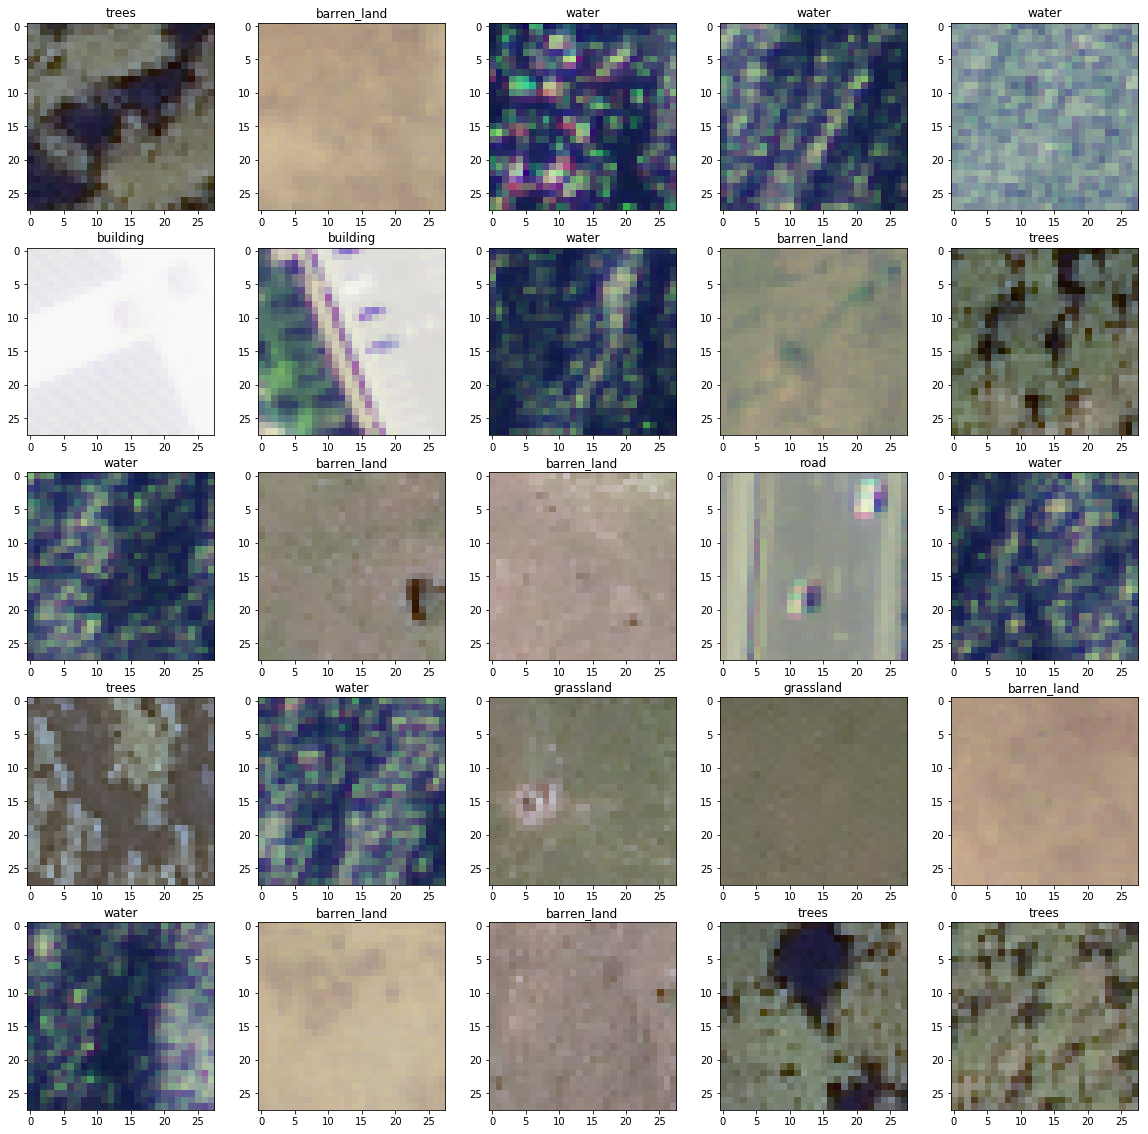

In [14]:
fig, axs = plt.subplots(5, 5, figsize = (20, 20))
for i, ax in enumerate(axs.flatten()):
    ax.set_title(get_labels(training_labels.iloc[i].values))
    ax.imshow(row_to_img(X_train.iloc[i].values))

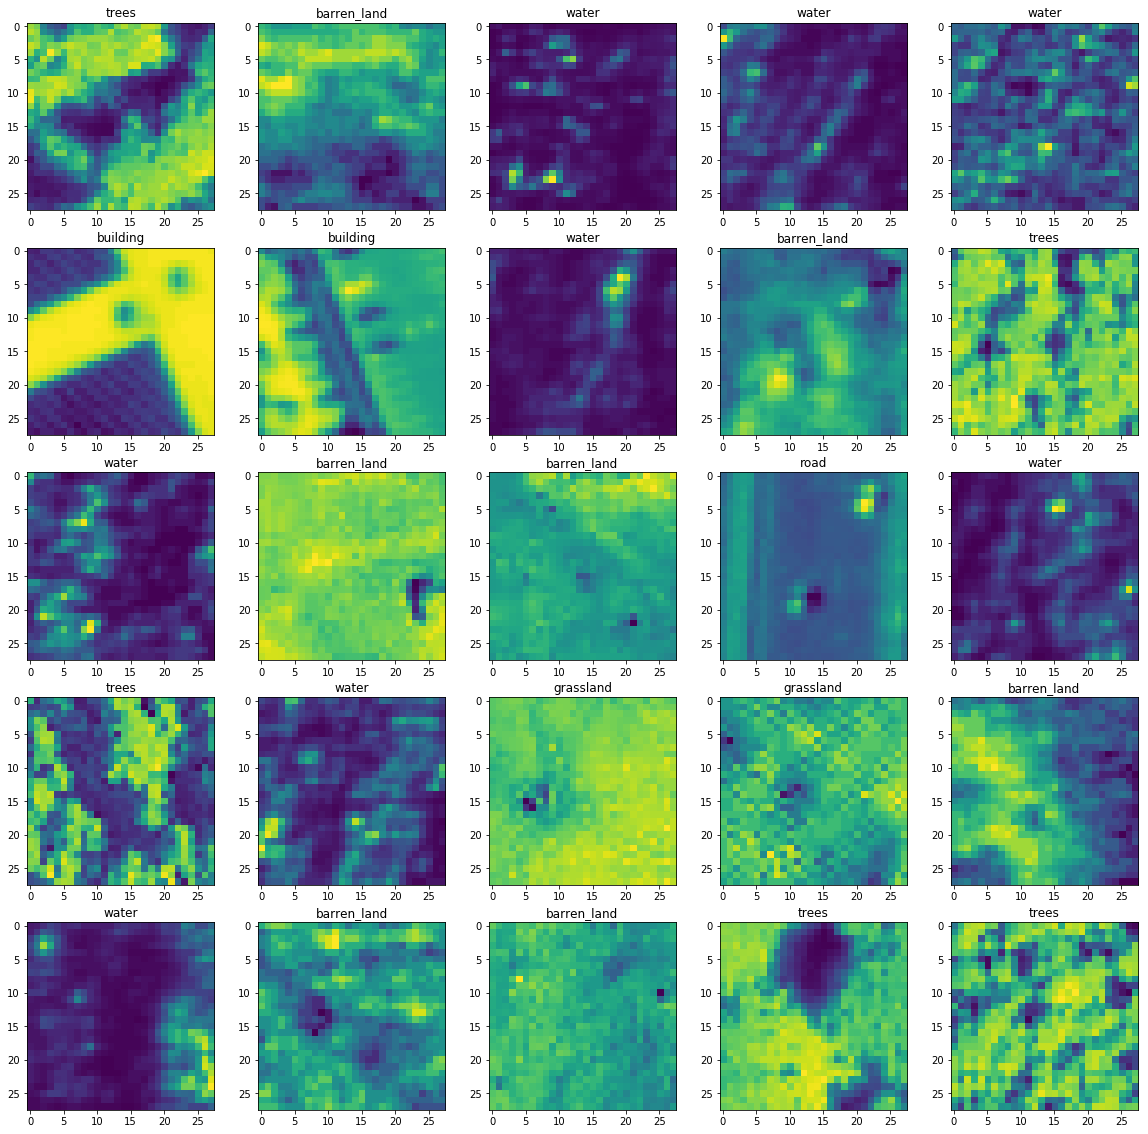

In [15]:
fig, axs = plt.subplots(5, 5, figsize = (20, 20))
for i, ax in enumerate(axs.flatten()):
    ax.set_title(get_labels(training_labels.iloc[i].values))
    ax.imshow(row_to_img(X_train.iloc[i].values, ir=True))

Dimensionality Reduction and Cluster Analysis
---
We can get a sense of how clearly defined our image classes are by projecting sample images down to 2D space and visualizing them. Let us first try using PCA to visualize the sample, then TSNE. If two principal components are not enough to achieve a 95% explained variance score, let us calculate how many principal components are necessary to achieve that. We will use the first 100 rows in the training set as our sample.

In [16]:
sample = X_train.copy()
sample['labels'] = [get_labels(x.values) for i, x in training_labels[:300].iterrows()]

In [17]:
pca = PCA(n_components=2)
components = pd.DataFrame(pca.fit_transform(sample.drop('labels', axis=1)), columns=['component_1', 'component_2'])
components['labels'] = sample['labels']

In [18]:
components.head()

,component_1,component_2,labels
0,-937.353162,1195.035981,trees
1,3173.150592,-282.175904,barren_land
2,-3104.479505,-503.230050,water
3,-3090.313396,-589.897575,water
4,-652.327617,-2494.766648,water


In [19]:
subsets = [components.loc[components['labels'] == x] for x in classes]

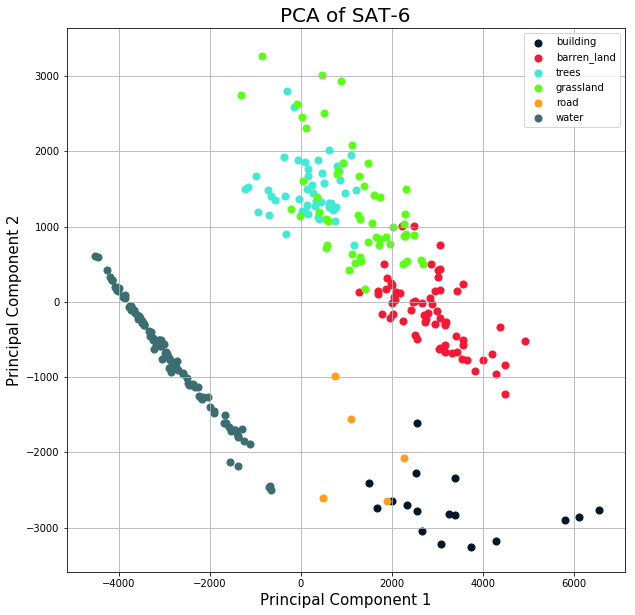

In [20]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA of SAT-6', fontsize = 20)

color_map = {'building': '#011627', 'barren_land': '#F71735', 'trees': '#41EAD4', 'grassland': '#5AFF15', 'road': '#FF9F1C', 'water': '#3C6E71'}

for subset in subsets:
    label = subset['labels'].values.tolist()[0]
    ax.scatter(x=subset['component_1'], y=subset['component_2'], s=50, c=color_map[label])

ax.legend(color_map.keys())
ax.grid()
plt.show()

Clearly the classes may be easily distinguised with a learner. The `water` class appears to be the most distinct. We see two more clusters between the `trees`, `grassland` and `barren_land` classes and the `building` and `road` classes.

In [21]:
pca.explained_variance_ratio_.cumsum()

array([0.66852571, 0.83619745])

We note that the 2 principal components constitute together only achieve an explained variance ratio of 83%.

In [22]:
pca_95 = PCA(n_components=0.95, svd_solver='full')
components_95 = pca_95.fit_transform(sample.drop('labels', axis=1))
components_95.shape

(300, 51)

We would need to include at least 51 components to achieve an explained variance ratio of 95%.

In [23]:
tsne = TSNE(n_components=2, perplexity=32)
components = pd.DataFrame(tsne.fit_transform(sample.drop('labels', axis=1)), columns=['component_1', 'component_2'])
components['labels'] = sample['labels']
components.head()

,component_1,component_2,labels
0,4.147885,20.695095,trees
1,-8.961695,9.389331,barren_land
2,8.082930,-22.204678,water
3,6.370546,-21.494564,water
4,6.487143,-14.392965,water


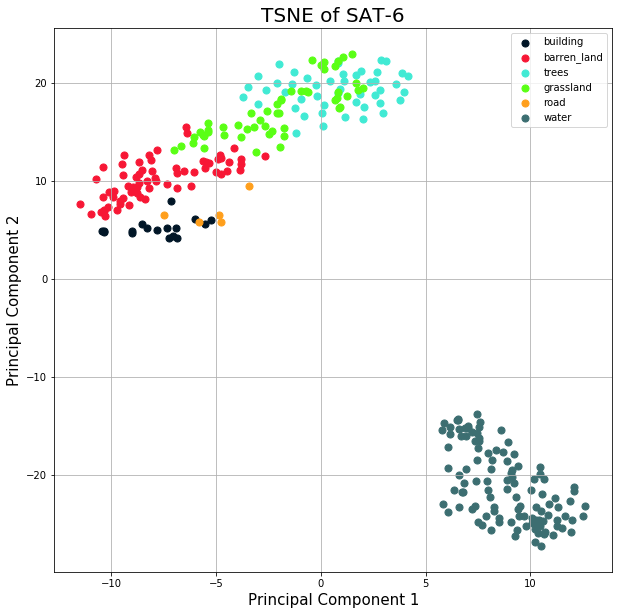

In [24]:
subsets = [components.loc[components['labels'] == x] for x in classes]
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('TSNE of SAT-6', fontsize = 20)

color_map = {'building': '#011627', 'barren_land': '#F71735', 'trees': '#41EAD4', 'grassland': '#5AFF15', 'road': '#FF9F1C', 'water': '#3C6E71'}

for subset in subsets:
    label = subset['labels'].values.tolist()[0]
    ax.scatter(x=subset['component_1'], y=subset['component_2'], s=50, c=color_map[label])

ax.legend(color_map.keys())
ax.grid()
plt.show()

The TSNE plot shows a similar relationship to the PCA except that the two clusters of the 5 classes excluding `water` are located much more closely together.

Baseline
---
Before training deep neural networks training on hundres of thousands of images, lets attempt to train at least a weak classifier on the subsample of data. Anything classifier that is 16% accurate or more is better than random.

For our baseline, we will use the a random forest classifier trained on 51 principal components.

In [25]:
clf = RandomForestClassifier(verbose=True)
X = components_95
y = sample['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [26]:
clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=True,
            warm_start=False)

In [27]:
clf.score(X_test, y_test)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


0.8533333333333334

In [28]:
y_pred = clf.predict(X_test)
print(classification_report(y_pred, y_test))

             precision    recall  f1-score   support

barren_land       1.00      0.78      0.88        23
   building       0.33      1.00      0.50         2
  grassland       0.82      0.75      0.78        12
       road       0.00      0.00      0.00         0
      trees       0.80      0.80      0.80        10
      water       1.00      0.96      0.98        28

avg / total       0.93      0.85      0.88        75



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Our classifier recieved an overall accuracy score of 85%. We see from the classification report that the model failed to correctly identify any `road` chips. It also struggled with `grassland`, `building`, and `trees` chips. We will attempt to correct these errors with a more robust classifier.